In [1]:
from IPython.core.display import HTML
HTML("""
<style>
div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.2em;
line-height:1.3em;
padding-left:0.1em;
padding-right:0.1em;
text-align: justify;
}

</style>
""")

In [2]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')

Метод роя частиц - группа методов глобальной оптимизации, основанных на моделировании поведения популяции частиц в пространстве параметров оптимизационной задачи. Данный метод является стохастическим. Здесь была произведена попытка реализации т.н. канонического метода роя частиц.

В данном методе заводится популяция частиц размером $N$, поведение которых описывается моделью следующего вида:

$$\upsilon_i(t+1) = w\upsilon_i(t) + c_1r_1(\ \overline{x}_i(t) - x_i(t)\ ) + c_2r_2(\ {g(t)-x_i(t)}\ )$$

, здесь $t$ - номер шага. $\upsilon_i$ - скорость $i$ - ой частицы $( i = \overline{1, N} )$. $w$ - коэффициент инерции. $c_1, c_2$ - коэффициенты ускорения. $r_1, r_2$ - случайные числа, распределенные равномерно на отрезке [0, 1].  $\overline{x}_i(t)$ - индивидуальное лучшее решение для $i$ - ой частицы на шаге $t$ (это координата наилучшего текущего решения). $g(t)$ - наилучшее решение всей популяции на шаге $t$.
Далее новые положения частиц определяются по формуле: 
$$x_i(t+1) = x_i(t) + \upsilon_i(t+1)$$

Первое слагаемое в формуле для скорости отвечает за сохранение скорости движения частицы, $w$ обычно лежит в диапазоне от 0.8 до 1.2, но не обязательно. Второе слагаемое отвечает за "память" частицы об индивидуальном лучшем решении. Третье слагаемое заставляет двигаться частицу в сторону лучшего на данный момент решения. $c_1, c_2$ - индивидуальный и социальный коэффициенты, которые лежат в диапазоне от 0 до 2. Обычно выбираются значения близкие к 2.

In [3]:
def F(X):
    return (X[:,0] ** 2 + X[:,1] ** 2)*0.01 - np.cos(5*X[:,0])*np.cos(10*X[:,1])
    #return ((X[:,0] - X[:,1]))*np.cos(X[:,0])*np.cos(X[:,1]*0.707) + 2

In [4]:
boundx = (-8, 22)
boundy = (-8, 22)
x_ = np.linspace(boundx[0], boundx[1], 500)
y_ = np.linspace(boundy[0], boundy[1], 500)
xx, yy = np.meshgrid(x_, y_)
XY_grid = np.hstack( [xx.reshape(-1, 1), yy.reshape(-1, 1)] )
Fxy = F(XY_grid).reshape(xx.shape)
del XY_grid

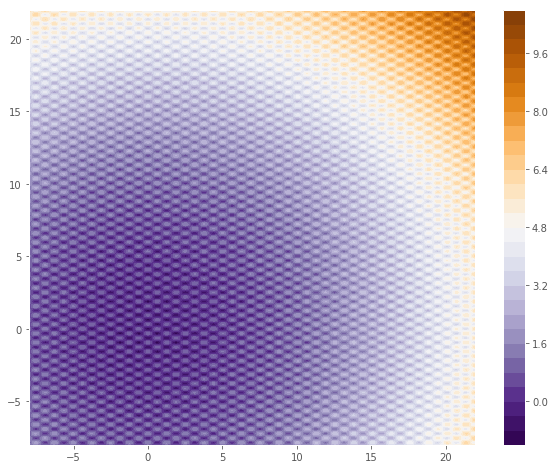

In [5]:
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Fxy, 30, cmap=plt.cm.PuOr_r,)
plt.colorbar()
plt.show()

In [6]:
### Размер популяции
N = 50
### Количество итераций
n_iter = 300
### Коэффициент инерции
w = 0.8
### Koэффициенты ускорения
c1 = 1.95
c2 = 1.95
### Фиксируем гсч
np.random.seed(12)
### Список границ области поиска
bounds = [boundx, boundy]
### Размерность вектора в пространстве оптимизации
d = len(bounds)
### Инициализация частиц случайными значениями в области поиска
P  = np.zeros((N, d))
for ax, boundd in enumerate(bounds):
    P[:, ax] = np.random.uniform(boundd[0], boundd[1], size=N)
### Координаты лучших индивидуальных результатов
Pi = np.zeros((N, d))
### Лучшие индивидуальные результаты
Fi = np.zeros(N) + np.inf
### Координаты лучших глобальных результатов
Pg = np.zeros((1, d))
### Лучшие глобальные результаты
Fg = np.inf
### Векторы скоростей
V = np.zeros((N, d))

##### Моделирование движения
### История перемещения какой-то частицы K и значений функции
way_history = np.array([])
F_history   = np.array([])
K = 0

for i in range(n_iter):
    r1 = np.random.uniform(0, 1, 1)
    r2 = np.random.uniform(0, 1, 1)
    ### Перемещение согласно модели
    V = w*V + c1*r1*(Pi - P) + c2*r2*(Pg - P)
    P = P + V
    ### Проверяем не улетаем ли за границу, если улетаем возвращаем на край
    for ax in range(d):
        V[P[:, ax] <= bounds[ax][0]] = 0
        P[P[:, ax] <= bounds[ax][0], ax] = bounds[ax][0]
        V[P[:, ax] >= bounds[ax][1]] = 0
        P[P[:, ax] >= bounds[ax][1], ax] = bounds[ax][1]
    ### Значение функции на новых положениях частиц
    F_curr = F(P)
    ### Индексы частиц которые "улучшили" своё положение
    mask_ibest = F_curr < Fi
    ### Обновляем вектор лучших индивидуальных позиций и результатов
    Fi[mask_ibest] = F_curr[mask_ibest]
    Pi[mask_ibest] = P[mask_ibest]
    ### Теперь для глобальных позиций и результатов
    mask_gbest = np.argmin(Fi)
    min_Fi = Fi[mask_gbest]
    if(Fg > min_Fi):
        Fg = min_Fi
        Pg = P[mask_gbest]
    ### Заполняем историю перемещения и результатов
    way_history = np.append(way_history, P[K])
    F_history   = np.append(F_history, F_curr[K])

In [7]:
way_history = way_history.reshape(-1, 2)

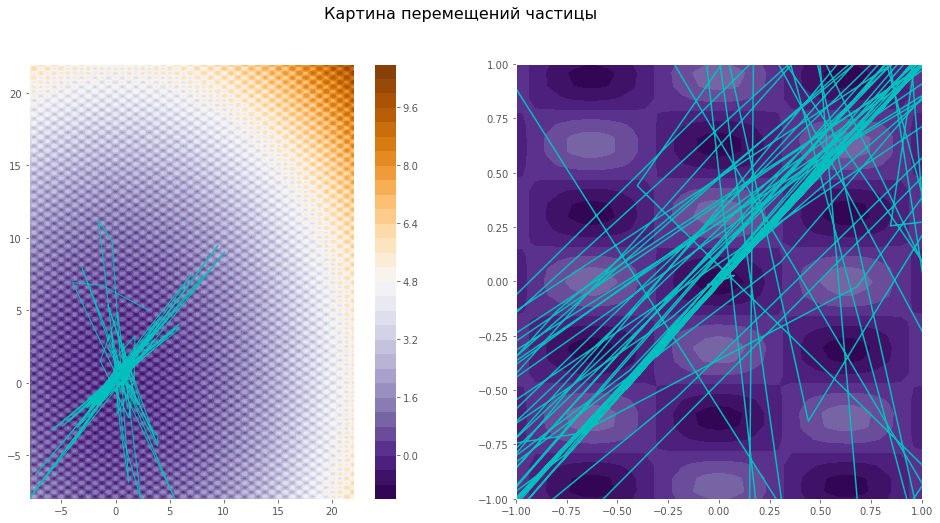

In [8]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.contourf(xx, yy, Fxy, 30, cmap=plt.cm.PuOr_r)
plt.colorbar()
plt.plot(way_history[:,0], way_history[:,1], zorder = 2, c = 'c', lw = 1)
plt.scatter(0,0, c = 'r', alpha=0.9)

plt.subplot(122)
plt.contourf(xx, yy, Fxy, 30, cmap=plt.cm.PuOr_r)
plt.plot(way_history[:,0], way_history[:,1], zorder = 2, c = 'c', lw = 1.5)
plt.scatter(0,0, c = 'r', zorder = 1, alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.suptitle(u'Картина перемещений частицы', fontsize = 16)
plt.show()

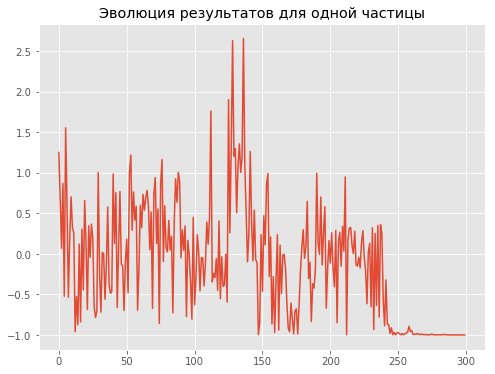

In [9]:
plt.figure(figsize=(8,6))
plt.plot(F_history)
plt.title(u'Эволюция результатов для одной частицы')
plt.show()

In [10]:
Pg, Fg

(array([  3.00755344e-05,   2.09987954e-05]), -0.9999999666323528)

In [11]:
def CPSO(Function , N = 10, w = 0.6, c1 = 1.95, c2 = 1.95, n_iter = 100, bounds = None, seed = 0):
    ### Function; Функция для которой ищется минимум
    ### N; Размер популяции
    ### w; Коэффициент инерции
    ### c1, c2; Koэффициенты ускорения
    ### bounds; Список границ области поиска
    ### seed!!!
    np.random.seed(seed)
    ### Размерность вектора в пространстве оптимизации
    d = len(bounds)
    ### Инициализация частиц случайными значениями в области поиска
    P  = np.zeros((N, d))
    for ax, boundd in enumerate(bounds):
        P[:, ax] = np.random.uniform(boundd[0], boundd[1], size=N)
    ### Координаты лучших индивидуальных результатов
    Pi = np.zeros((N, d))
    ### Лучшие индивидуальные результаты
    Fi = np.zeros(N) + np.inf
    ### Координаты лучших глобальных результатов
    Pg = np.zeros((1, d))
    ### Лучшие глобальные результаты
    Fg = np.inf
    ### Векторы скоростей
    V = np.zeros((N, d))
    
    ##### Моделирование движения
    for i in range(n_iter):
        r1 = np.random.uniform(0, 1, 1)
        r2 = np.random.uniform(0, 1, 1)
        ### Перемещение согласно модели
        V = w*V + c1*r1*(Pi - P) + c2*r2*(Pg - P)
        P = P + V
        ### Проверяем не улетаем ли за границу, если улетаем возвращаем на край
        for ax in range(d):
            V[P[:, ax] <= bounds[ax][0]] = 0
            P[P[:, ax] <= bounds[ax][0], ax] = bounds[ax][0]
            V[P[:, ax] >= bounds[ax][1]] = 0
            P[P[:, ax] >= bounds[ax][1], ax] = bounds[ax][1]
        ### Значение функции на новых положениях частиц
        F_curr = F(P)
        ### Индексы частиц которые "улучшили" своё положение
        mask_ibest = F_curr < Fi
        ### Обновляем вектор лучших индивидуальных позиций и результатов
        Fi[mask_ibest] = F_curr[mask_ibest]
        Pi[mask_ibest] = P[mask_ibest]
        ### Теперь для глобальных позиций и результатов
        mask_gbest = np.argmin(Fi)
        min_Fi = Fi[mask_gbest]
        if(Fg > min_Fi):
            Fg = min_Fi
            Pg = P[mask_gbest]
        print 'Iteration : %d'%i, 'F = %.5f'%Fg
    return Pg, Fg

In [12]:
CPSO(Function=F, N = 150, w = 0.8, c1 = 1.95, c2 = 1.95, n_iter = 500, bounds=[boundx, boundy], seed = 0)

Iteration : 0 F = -0.15570
Iteration : 1 F = -0.63283
Iteration : 2 F = -0.79204
Iteration : 3 F = -0.86956
Iteration : 4 F = -0.86956
Iteration : 5 F = -0.86956
Iteration : 6 F = -0.86956
Iteration : 7 F = -0.89798
Iteration : 8 F = -0.89798
Iteration : 9 F = -0.89798
Iteration : 10 F = -0.92162
Iteration : 11 F = -0.92162
Iteration : 12 F = -0.98428
Iteration : 13 F = -0.98428
Iteration : 14 F = -0.98428
Iteration : 15 F = -0.98428
Iteration : 16 F = -0.98428
Iteration : 17 F = -0.98428
Iteration : 18 F = -0.98428
Iteration : 19 F = -0.98428
Iteration : 20 F = -0.99387
Iteration : 21 F = -0.99387
Iteration : 22 F = -0.99387
Iteration : 23 F = -0.99387
Iteration : 24 F = -0.99387
Iteration : 25 F = -0.99387
Iteration : 26 F = -0.99584
Iteration : 27 F = -0.99584
Iteration : 28 F = -0.99584
Iteration : 29 F = -0.99584
Iteration : 30 F = -0.99584
Iteration : 31 F = -0.99584
Iteration : 32 F = -0.99584
Iteration : 33 F = -0.99584
Iteration : 34 F = -0.99584
Iteration : 35 F = -0.99584
It

Iteration : 364 F = -0.99999
Iteration : 365 F = -0.99999
Iteration : 366 F = -0.99999
Iteration : 367 F = -0.99999
Iteration : 368 F = -0.99999
Iteration : 369 F = -0.99999
Iteration : 370 F = -0.99999
Iteration : 371 F = -0.99999
Iteration : 372 F = -0.99999
Iteration : 373 F = -0.99999
Iteration : 374 F = -0.99999
Iteration : 375 F = -0.99999
Iteration : 376 F = -0.99999
Iteration : 377 F = -0.99999
Iteration : 378 F = -0.99999
Iteration : 379 F = -0.99999
Iteration : 380 F = -0.99999
Iteration : 381 F = -0.99999
Iteration : 382 F = -0.99999
Iteration : 383 F = -0.99999
Iteration : 384 F = -0.99999
Iteration : 385 F = -0.99999
Iteration : 386 F = -0.99999
Iteration : 387 F = -0.99999
Iteration : 388 F = -0.99999
Iteration : 389 F = -0.99999
Iteration : 390 F = -1.00000
Iteration : 391 F = -1.00000
Iteration : 392 F = -1.00000
Iteration : 393 F = -1.00000
Iteration : 394 F = -1.00000
Iteration : 395 F = -1.00000
Iteration : 396 F = -1.00000
Iteration : 397 F = -1.00000
Iteration : 39

(array([ -3.36344455e-06,   1.45472960e-06]), -0.99999999975264431)